In [48]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,ReLU,Conv2D,MaxPool2D,Flatten
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay
import itertools

In [35]:
train_dataset = os.path.join("Leaf Data",'Train2')
test_dataset = os.path.join('Leaf Data','Test2')

In [36]:
rescale = preprocessing.Rescaling(scale=1.0/255)

train = image_dataset_from_directory(directory=train_dataset,image_size=(128, 128))
test = image_dataset_from_directory(directory=test_dataset,image_size=(128, 128))

train_gen = train.map(lambda image,label:(rescale(image),label))
test_gen  = test.map(lambda image,label:(rescale(image),label))

Found 1032 files belonging to 5 classes.
Found 118 files belonging to 5 classes.


In [4]:
model = Sequential()

In [5]:
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(128,128,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [6]:
# Loss Function : sparse_categorical_crossentropy
# learning Rate : 0.0001
# Optimizer : adam
# metrics : accuracy

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [8]:
# Model Traning
history = model.fit(train_gen,validation_data=test_gen,epochs=20,verbose=1,batch_size=32)

Epoch 1/20
33/33 [==============================] - 8s 121ms/step - loss: 1.1733 - accuracy: 0.6143 - val_loss: 1.0300 - val_accuracy: 0.6356
Epoch 2/20
33/33 [==============================] - 3s 80ms/step - loss: 0.6980 - accuracy: 0.7171 - val_loss: 1.0138 - val_accuracy: 0.6356
Epoch 3/20
33/33 [==============================] - 3s 80ms/step - loss: 0.6174 - accuracy: 0.7413 - val_loss: 1.1859 - val_accuracy: 0.5932
Epoch 4/20
33/33 [==============================] - 3s 80ms/step - loss: 0.5560 - accuracy: 0.7558 - val_loss: 0.9250 - val_accuracy: 0.6525
Epoch 5/20
33/33 [==============================] - 3s 84ms/step - loss: 0.5406 - accuracy: 0.7810 - val_loss: 1.2623 - val_accuracy: 0.5763
Epoch 6/20
33/33 [==============================] - 3s 80ms/step - loss: 0.5114 - accuracy: 0.7946 - val_loss: 0.9476 - val_accuracy: 0.6864
Epoch 7/20
33/33 [==============================] - 3s 80ms/step - loss: 0.4480 - accuracy: 0.8246 - val_loss: 0.7786 - val_accuracy: 0.7034
Epoch 8/20
3

In [9]:
# Model evalution / prediction
a = model.evaluate(test)

4/4 [==============================] - 0s 26ms/step - loss: 146.1229 - accuracy: 0.8729


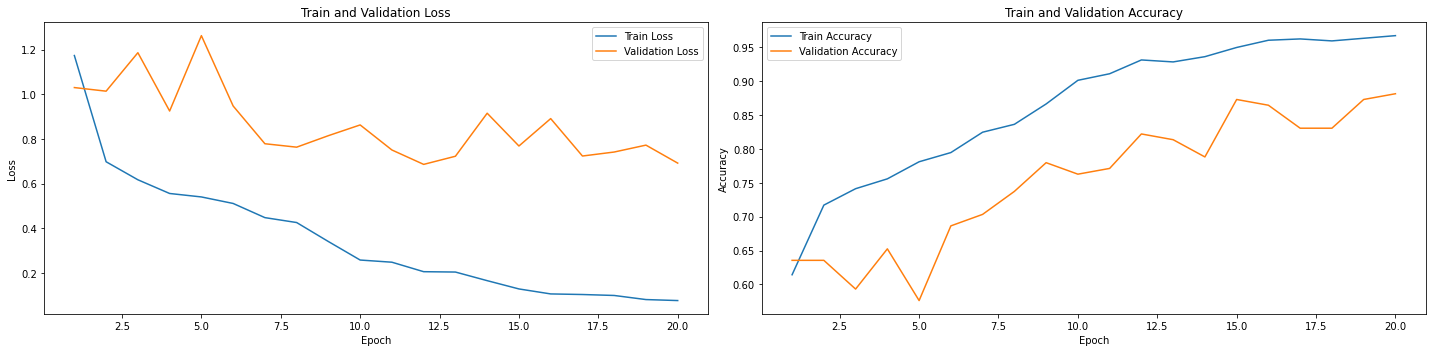

In [40]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1,21),history.history['loss'],label="Train Loss")
plt.plot(range(1,21),history.history['val_loss'], label="Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1,21),history.history['accuracy'], label="Train Accuracy")
plt.plot(range(1,21),history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.tight_layout()

In [24]:
data = {}
for i in range(len(test.class_names)):
    data[i] = test.class_names[i]
    
data

{0: 'Soybean_Bacterial_Spot',
 1: 'Soybean_Brown_Spot',
 2: 'Soybean_Healthy_Leaf',
 3: 'Soybean_Leaf_Rust',
 4: 'Soybean_Mosaic_Virus'}

In [37]:
test_img = cv2.imread(os.path.join("Leaf Data/Test2/Soybean_Bacterial_Spot/Soybean_bacterial_spot_39.jpeg"))
test_img = tf.expand_dims(test_img,0)
result = np.argmax(model.predict(test_img))
print("Model Prediction is : ",data[result])

Model Prediction is :  Soybean_Bacterial_Spot


In [34]:
model.save("Leaf_Model.hdf5")

In [49]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())
    
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [50]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 96.71 %
Test Accuracy   : 88.14 %
Precision Score : 88.14 %
Recall Score    : 88.14 %


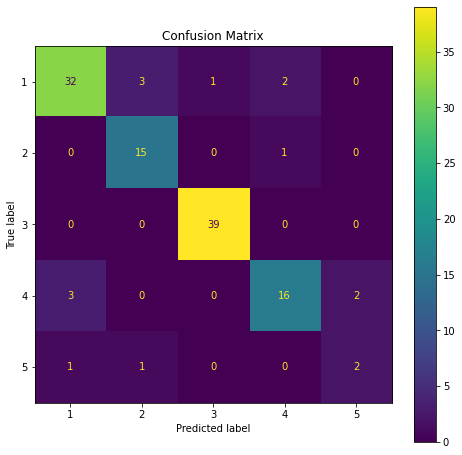

In [56]:
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,6)))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()